In [1]:
import imprint.nb_util as nb_util
nb_util.setup_nb()

import time
import jax
import jax.numpy as jnp
from jax.scipy.special import expit, logit
import numpy as np
import matplotlib.pyplot as plt

import confirm.models.wd41 as wd41
import imprint as ip

## Exploring

We have two subgroups, each split equally into treatment and control arms:
- $p_{\mathrm{TNBC}}^{c}$ - TNBC subgroup control arm effectiveness.
- $p_{\mathrm{TNBC}}^{t}$ - TNBC subgroup treatment arm effectiveness.
- $p_{\mathrm{HR+}}^{c}$ - HR+ subgroup control arm effectiveness.
- $p_{\mathrm{HR+}}^{t}$ - HR+ subgroup treatment arm effectiveness.
  
$f_{\mathrm{TNBC}}$ is the fraction of patients in the TNBC subgroup.

The null hypotheses here are:

$$
p_{\mathrm{TNBC}}^{c} > p_{\mathrm{TNBC}}^{t}
$$

$$
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{c} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{c} > 
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{t} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{t}
$$

In [2]:
theta_tnbc_c = -1
p_tnbc_c = expit(theta_tnbc_c)
theta_hrplus_c = -1
p_hrplus_c = expit(theta_hrplus_c)


def get_theta(theta):
    t_tnbc_t = theta[..., 0]
    return jnp.stack(
        (
            jnp.full_like(t_tnbc_t, theta_tnbc_c),
            t_tnbc_t,
            jnp.full_like(t_tnbc_t, theta_hrplus_c),
            theta[..., 1],
        ),
        axis=-1,
    )


class WD41Null2D(wd41.WD41Null):
    def get_theta(self, theta):
        return get_theta(theta)


class WD412D(wd41.WD41):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.family_params = {
            "n": jnp.array(
                [
                    self.n_max_tnbc,
                    self.n_max_hrplus,
                ]
            )
        }

    def sim_batch(
        self,
        begin_sim: int,
        end_sim: int,
        theta: jnp.ndarray,
        null_truth: jnp.ndarray,
        detailed: bool = False,
    ):
        return super().sim_batch(
            begin_sim,
            end_sim,
            get_theta(theta),
            null_truth,
            detailed,
        )


model = WD412D(0, 1)
nulls = [ip.hypo("-1 > theta0"), WD41Null2D(model.true_frac_tnbc)]

grid = ip.cartesian_grid([-2.5, -2.5], [-0.0, -0.0], n=[90, 90], null_hypos=nulls)


DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=8100, worker_id=1, t=1677530255, n_bits=18, worker_bits=18) = [4598536890151600128 4598536890151600129 4598536890151600130, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=338, worker_id=1, t=1677530256, n_bits=18, worker_bits=18) = [4598536958871076864 4598536958871076865 4598536958871076866, ...]:


In [28]:
val_df = ip.validate(WD412D, g=grid, lam=0.025, K=10000)

In [29]:
theta = grid.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)

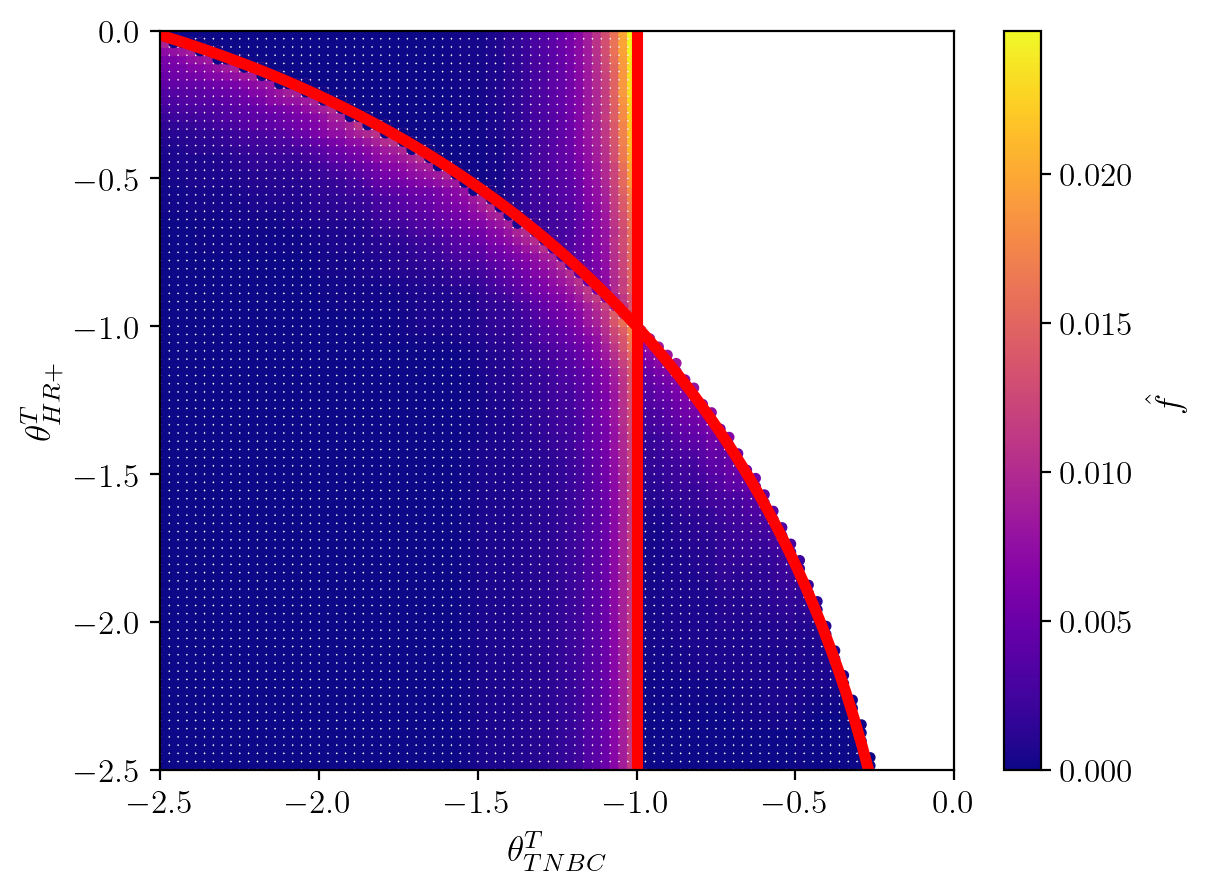

In [30]:
plt.scatter(theta[:,0], theta[:,1], c=val_df['tie_est'], s=8)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\hat{f}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.show()

In [32]:
cal_df = ip.calibrate(WD412D, g=grid, alpha=0.025, K=10000)

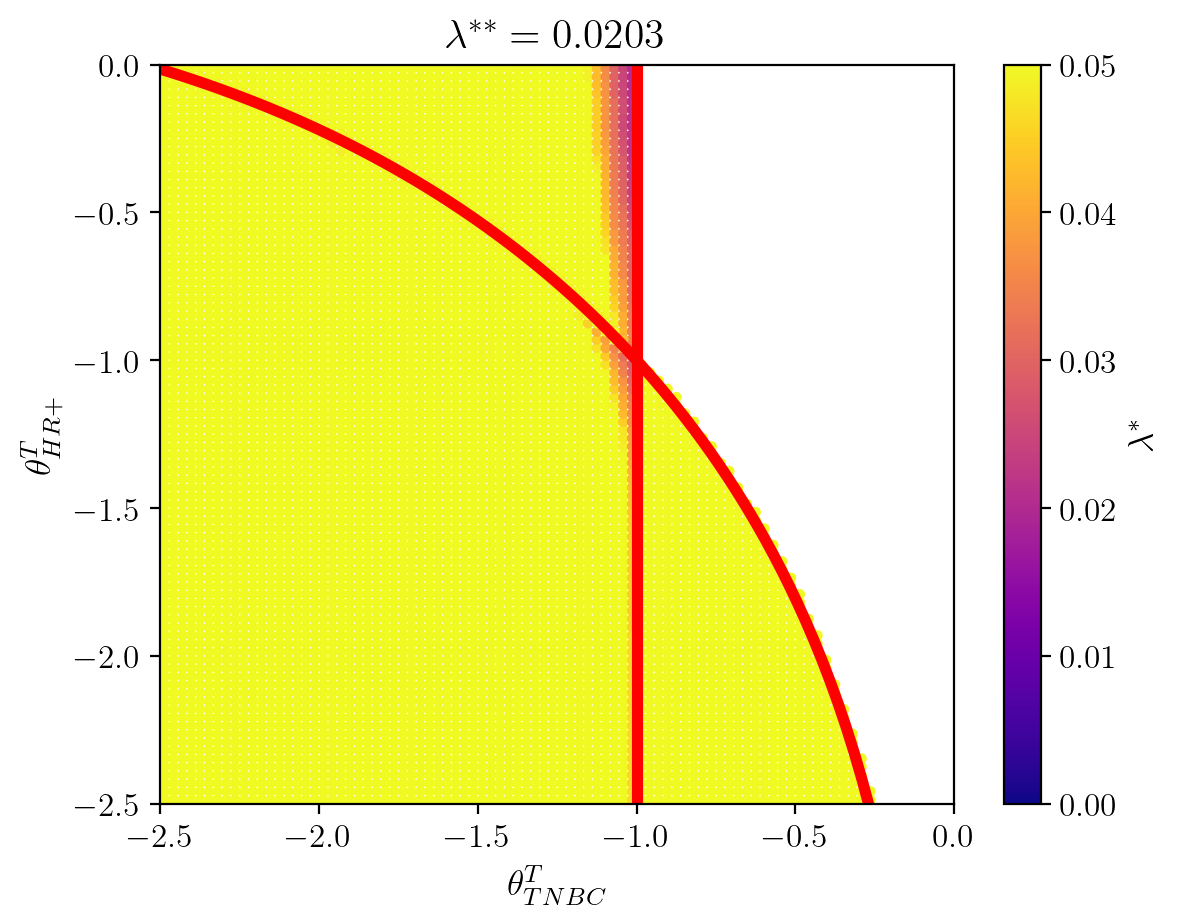

In [35]:
plt.scatter(theta[:,0], theta[:,1], c=cal_df['lams'], s=8, vmin=0, vmax=0.05)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{cal_df["lams"].min():.4f}$')
plt.show()

## Bigger job

In [3]:
from confirm.adagrid import ada_calibrate

In [5]:
grid = ip.cartesian_grid(
    [-2.5, -2.5],
    [1.0, 1.0],
    n=[10, 10],
    null_hypos = nulls
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1677530292, n_bits=18, worker_bits=18) = [4598539432772239360 4598539432772239361 4598539432772239362, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=20, worker_id=1, t=1677530293, n_bits=18, worker_bits=18) = [4598539501491716096 4598539501491716097 4598539501491716098, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=30, worker_id=1, t=1677530294, n_bits=18, worker_bits=18) = [4598539570211192832 4598539570211192833 4598539570211192834, ...]:


In [18]:
db = ada_calibrate(
    WD412D,
    db=db,
    alpha=0.025,
    bias_target=0.0005,
    grid_target=0.0005,
    std_target=0.0015,
    calibration_min_idx=80,
    step_size=2**13,
    packet_size=2**12,
    overrides=dict(
        bias_target=0.0005,
        grid_target=0.0005,
        std_target=0.0015
    )
)

DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB lock.
INFO:confirm.adagrid.calibration:[worker_id=6] 
Preparing new step with 8192 parent tiles.
DEBUG:confirm.adagrid.db:[worker_id=6] 
finish:                     id  step_id  step_iter  active  finisher_id  refine  \
0  4598552077156220929        8          6   False            6    True   
1  4598552077156220928        8          7   False            6    True   
2  4598552077156220936        8          0   False            6    True   
3  4598552077156220934        8          1   False            6    True   
4  4598552077156220935        8          1   False            6    True   

   deepen  split  
0   False  False  
1   False  False  
2   False  False  
3   False  False  
4   False  False  
DEBUG:imprint.grid:[worker_id=6] 
_gen_short_uuids(n=1458, worker_id=6, t=1677530683, n_bits=18, worker_bits=18) = [4598566302088953856 4598566302088953857 4598566302088953858, ...]:
DEBUG:imprint.grid:

In [36]:
g_r = ip.grid.Grid(db.get_results(), None).prune_inactive()

In [37]:
g_r.n_tiles

110927

In [49]:
B_lams = np.array([g_r.df[f'B_lams{i}'].min() for i in range(50)])
lamss = g_r.df['lams'].min()
B_lams, lamss, lamss - B_lams.mean()

(array([0.02322953, 0.02448712, 0.02272768, 0.02424303, 0.0233657 , 0.02298344, 0.0246517 ,
        0.02422191, 0.02431205, 0.02435009, 0.02412491, 0.02442573, 0.02476646, 0.02431205,
        0.02360044, 0.0234183 , 0.02385168, 0.02412491, 0.02405344, 0.02272768, 0.02272995,
        0.02424303, 0.02448313, 0.02405344, 0.02435009, 0.02326829, 0.02345565, 0.024524  ,
        0.02340358, 0.02385168, 0.0233684 , 0.02435009, 0.02390664, 0.02402381, 0.02365959,
        0.02428911, 0.02402381, 0.02308509, 0.02359362, 0.02232544, 0.02359362, 0.02326829,
        0.02322953, 0.02322953, 0.02448712, 0.0233657 , 0.02359362, 0.02326829, 0.02410076,
        0.02360044], dtype=float32),
 0.023851682,
 7.7618286e-05)

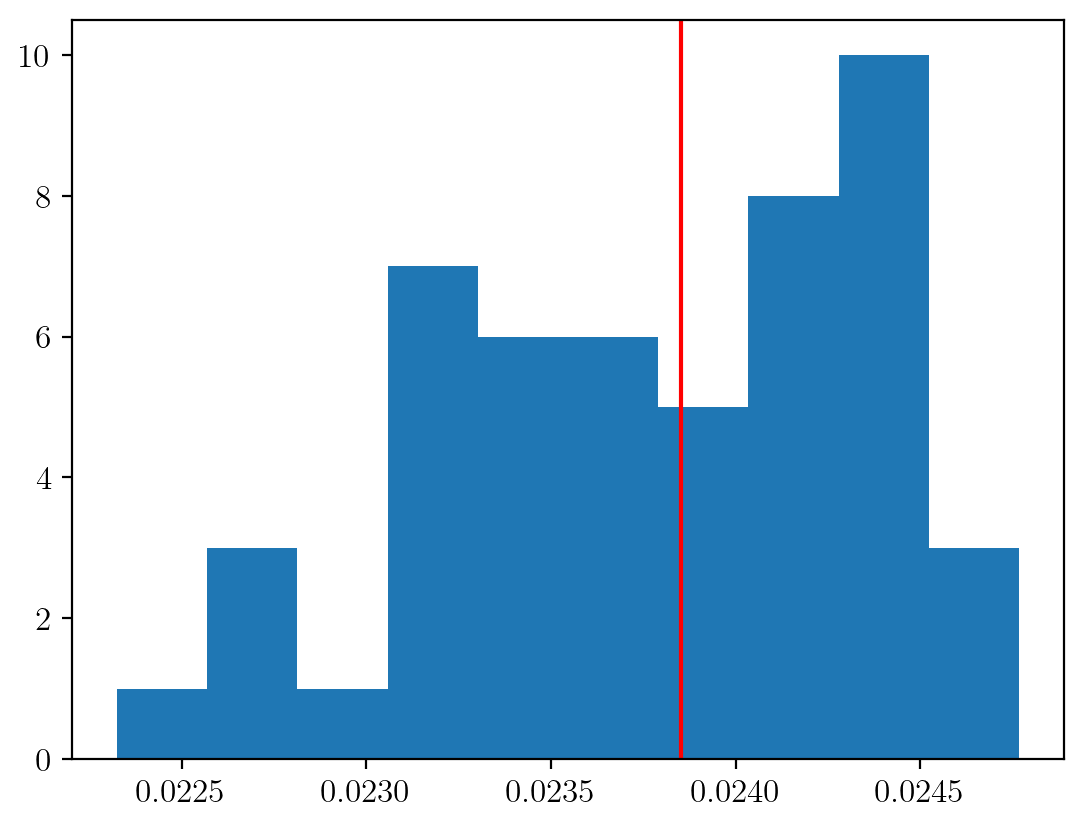

In [39]:

plt.hist(B_lams)
plt.axvline(lamss, color='r')
plt.show()

In [40]:
ordering = g_r.df['orderer'].sort_values()
ordering

94724     0.022676
90676     0.022676
105468    0.022676
105467    0.022676
105466    0.022676
            ...   
17197     1.000000
17196     1.000000
17195     1.000000
14133     1.000000
26677     1.000000
Name: orderer, Length: 110927, dtype: float64

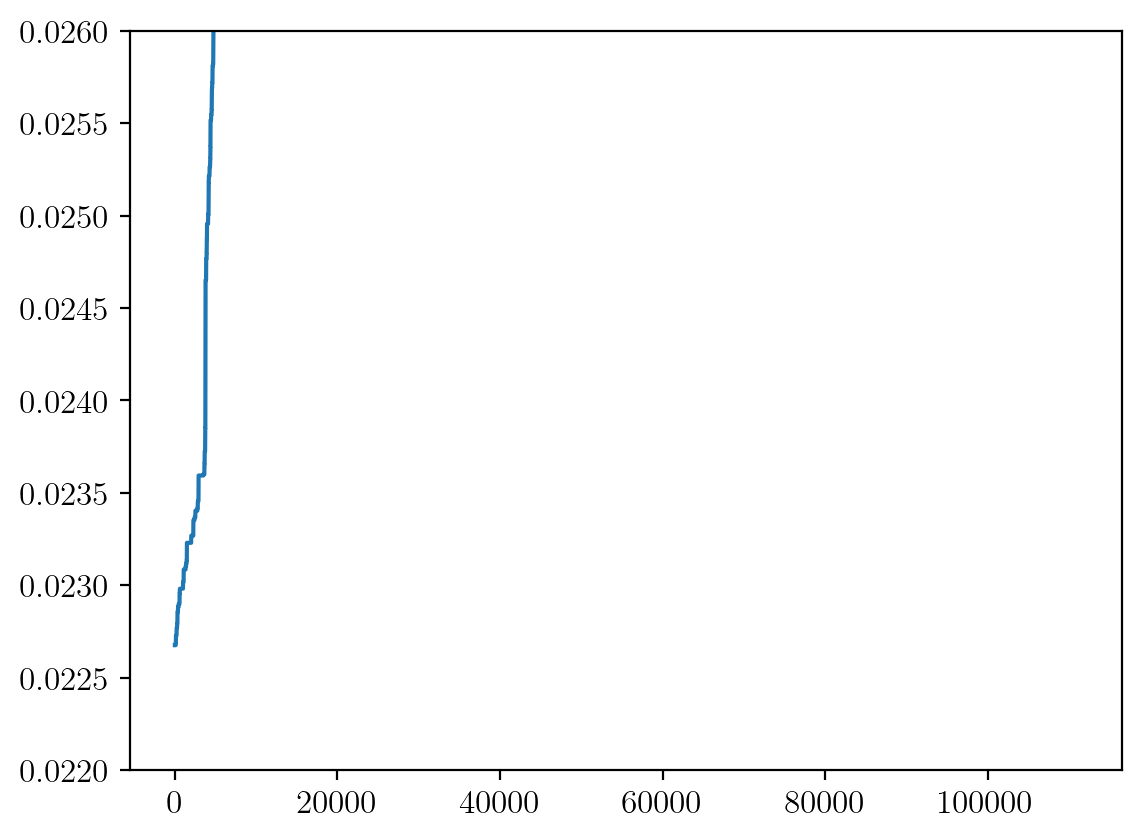

In [41]:
plt.plot(ordering.values)
plt.ylim([0.022, 0.026])
plt.show()

In [42]:
worst_tile = g_r.df.loc[g_r.df['lams'].idxmin()]
worst_tile[['theta0', 'theta1', 'radii0', 'radii1', 'orderer', "alpha0", 'K', 'lams']]

theta0    -1.000391
theta1     0.998633
radii0     0.000391
radii1     0.001367
orderer    0.022676
alpha0     0.024625
K             65536
lams       0.023852
Name: 78515, dtype: object

In [43]:
np.searchsorted(ordering, worst_tile['orderer']), ordering.shape

(0, (110927,))

In [48]:
B_worst_tile = [g_r.df.loc[g_r.df[f'B_lams{i}'].idxmin()] for i in range(50)]
[(B_worst_tile[i]['orderer'], np.searchsorted(ordering, B_worst_tile[i]['orderer'])) for i in range(50)]

[(0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 (0.02267555519938469, 0),
 

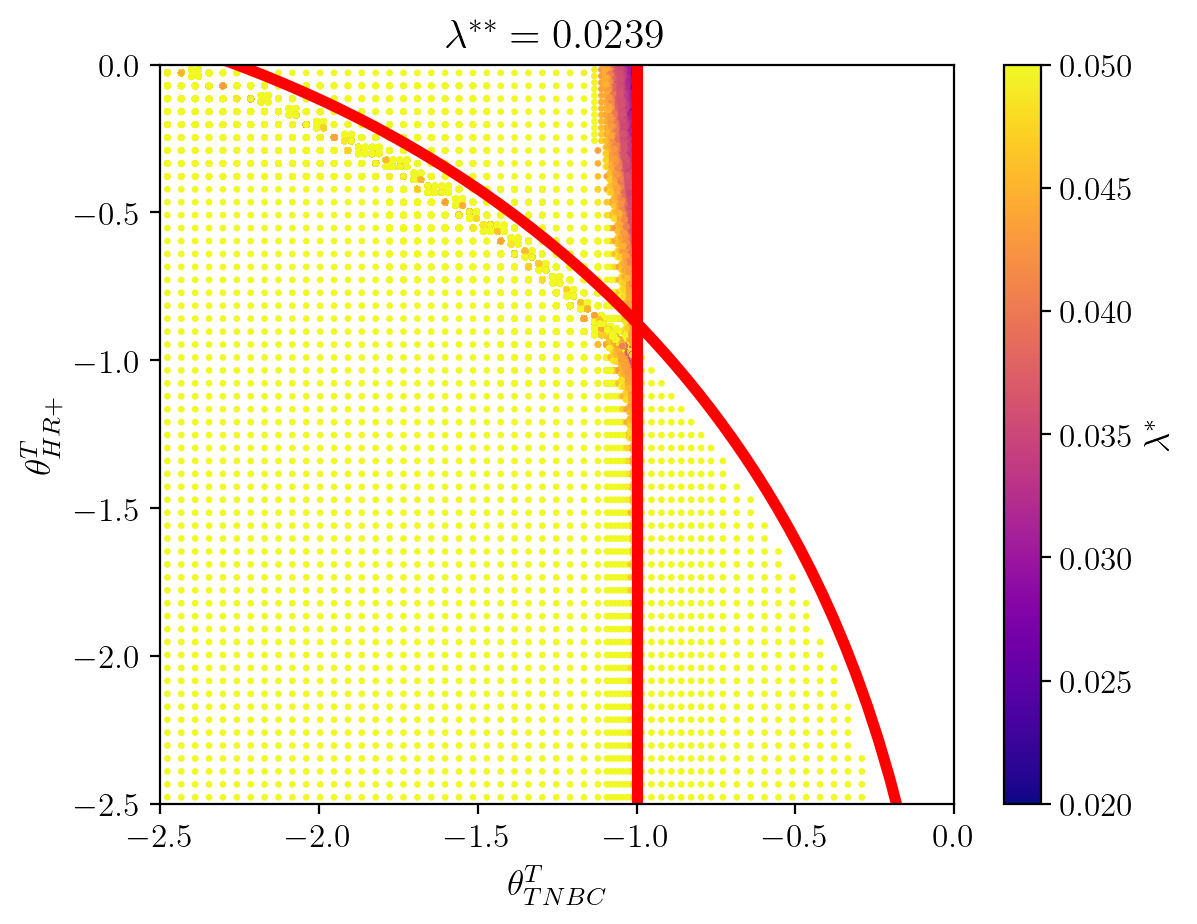

In [55]:
theta = g_r.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p[0, 0] * f + p[0, 2] * (1 - f)) - (ptt * f)) / (1 - f)
plt.scatter(theta[:,0], theta[:,1], c=g_r.df['lams'], s=2, vmin=0.02, vmax=0.05)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{lamss:.4f}$')
plt.show()